In [31]:
#libraries
import pandas as pd
from tabulate import tabulate
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import scipy.stats as stats
import warnings

In [32]:
def read_csv_or_fail(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Cannot read the data from '{file_path}' - File not found.")
    except pd.errors.EmptyDataError:
        print(f"Cannot read the data from '{file_path}' - Empty file.")
    except pd.errors.ParserError:
        print(f"Cannot read the data from '{file_path}' - Error parsing the CSV file.")
    return None

data = read_csv_or_fail("mv_test2.csv")
data["mean"] = data[["score1","score2"]].mean(axis=1)


if data is not None:
    data.drop('ID', axis=1, inplace=True)
    print(data)
else:
    print("Data load failed.")



       bad  score1  score2   mean
0        1     441     584  512.5
1        1     448     689  568.5
2        1     450     644  547.0
3        1     451     645  548.0
4        1     452     638  545.0
...    ...     ...     ...    ...
49994    0     798     650  724.0
49995    0     798     650  724.0
49996    0     798     651  724.5
49997    0     798     655  726.5
49998    0     798     656  727.0

[49999 rows x 4 columns]


In [33]:
def get_info(df):
    print("General Info:")
    print(tabulate({"Column": df.columns,
                    "Non-Null Count": df.count(),
                    "Data Type": df.dtypes},
                   headers="keys", tablefmt="pretty"))
    print("\n")

    print("Descriptive Statistics:")
    print(tabulate(df.describe(), headers="keys", tablefmt="pretty"))
    print("\n")

    print("Count of Missing Values:")
    print(tabulate({"Column": df.columns,
                    "Missing Count": df.isnull().sum(),
                    "Percentage Missing": (df.isnull().sum() / len(df)) * 100},
                   headers="keys", tablefmt="pretty"))
    print("\n")

    print("Correlation:")
    print(tabulate(df.corr(), headers="keys", tablefmt="pretty"))
    print("\n")

    print("Unique Values:")
    print(tabulate({"Column": df.columns, "Unique Count": df.nunique()},
                   headers="keys", tablefmt="pretty"))
    print("\n")


    print("Data Types:")
    print(tabulate({"Column": df.columns, "Data Type": df.dtypes},
                   headers="keys", tablefmt="pretty"))
    print("\n")

    print("Histograms:")
    df.hist()
    plt.show()

    print("Box Plots:")
    df.boxplot()
    plt.show()

General Info:
+--------+----------------+-----------+
| Column | Non-Null Count | Data Type |
+--------+----------------+-----------+
|  bad   |     49999      |   int64   |
| score1 |     49999      |   int64   |
| score2 |     49999      |   int64   |
|  mean  |     49999      |  float64  |
+--------+----------------+-----------+


Descriptive Statistics:
+-------+---------------------+-------------------+-------------------+-------------------+
|       |         bad         |      score1       |      score2       |       mean        |
+-------+---------------------+-------------------+-------------------+-------------------+
| count |       49999.0       |      49999.0      |      49999.0      |      49999.0      |
| mean  | 0.38140762815256307 | 690.1745234904698 | 669.5419908398168 | 679.8582571651433 |
|  std  | 0.48573713904265375 | 64.79700431525498 | 69.01088415525417 | 58.56045946256813 |
|  min  |         0.0         |       441.0       |       550.0       |       505.0     

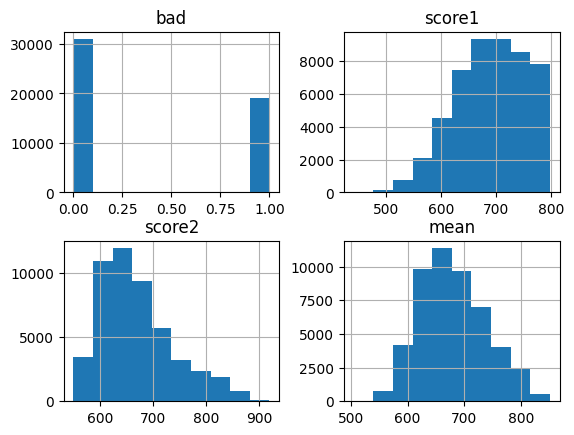

Box Plots:


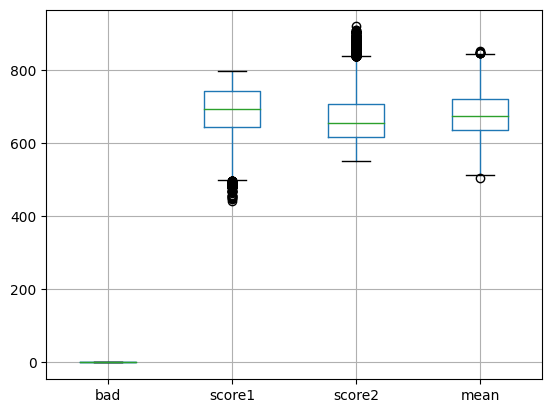

In [34]:
get_info(data)

In [35]:
#Creating small function to calculating divergence score
def calculate_divergence(df: pd.DataFrame):
    mu_good, sigma_good = df.loc[df['bad'] == 0, 'score1'].mean(), df.loc[df['bad'] == 0, 'mean'].std()
    mu_bad, sigma_bad = df.loc[df['bad'] == 1, 'mean'].mean(), df.loc[df['bad'] == 1, 'mean'].std()
    divergence = 2 * (mu_good - mu_bad)**2 / (sigma_good**2 + sigma_bad**2)
    return divergence


In [36]:
print("Divergence score = " + str(calculate_divergence(data)))


Divergence score = 1.4668990523235088


In [37]:
#Setting bin sizes with starting and ending bins. Can be modified for different results
starting_bin = 500
ending_bin = 820
bin_increment = 20
number_of_bins = int((ending_bin - starting_bin) / bin_increment) + 1

In [38]:
def create_table(df, starting_bin, ending_bin, bin_increment, score=str, total_number=str, bad_number=str, bad_rate=str):
  df = pd.DataFrame({total_number: df[score],
                        bad_number: df["bad"]})

  my_list = []
  my_list.append(0)
  for i in range(starting_bin, ending_bin, bin_increment):
    my_list.append(i)
  my_list.append(np.inf)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    result = df.groupby(pd.cut(df[total_number], my_list, right=False)).apply(lambda x: pd.Series({
        total_number: x[total_number].count(),
        bad_number: x[bad_number].astype(bool).sum(),
        bad_rate: x[bad_number].astype(bool).sum() / x[total_number].count()
    }))

  return result


In [39]:
def concat_tables(df, number_of_scores):
    scores = []
    for i in range(1, number_of_scores+1):
      scores.append('score' + str(i))
    dfs = []
    for score in scores:
      df_temp = create_table(df, starting_bin, ending_bin, bin_increment, score, f'Total # ({score})', f'Bads # ({score})', f'Bad rate ({score})')
      dfs.append(df_temp)
    df_concat = pd.concat(dfs, axis=1)
    df_concat.index.name="Score Bands"

    return df_concat
df_concat = concat_tables(data, 2)


In [40]:
table_1 = create_table(data, starting_bin, ending_bin, bin_increment, "score1", 'Total # (S1)', 'Bads # (S1)', 'Bad rate (S1)')
table_2 = create_table(data, starting_bin, ending_bin, bin_increment, "score2", 'Total # (S2)', 'Bads # (S2)', 'Bad rate (S2)')
df_concat = pd.concat([table_1, table_2], axis=1)
df_concat

,Total # (S1),Bads # (S1),Bad rate (S1),Total # (S2),Bads # (S2),Bad rate (S2)
"[0.0, 500.0)",88.0,77.0,0.875000,0.0,0.0,NaN
"[500.0, 520.0)",153.0,136.0,0.888889,0.0,0.0,NaN
"[520.0, 540.0)",366.0,306.0,0.836066,0.0,0.0,NaN
"[540.0, 560.0)",848.0,684.0,0.806604,292.0,198.0,0.678082
"[560.0, 580.0)",1208.0,939.0,0.777318,1957.0,1240.0,0.633623
"[580.0, 600.0)",2062.0,1509.0,0.731814,4523.0,2698.0,0.596507
"[600.0, 620.0)",2814.0,1906.0,0.677328,6321.0,3408.0,0.539155
"[620.0, 640.0)",3754.0,2232.0,0.594566,6793.0,3080.0,0.453408
"[640.0, 660.0)",4760.0,2492.0,0.523529,6229.0,2382.0,0.382405
"[660.0, 680.0)",5132.0,2278.0,0.443882,5575.0,1840.0,0.330045


In [41]:
#Changing pandas series to float to calculate the log odds of Score 1 and Score 2
def calculate_log_odds(df, number):
  question3_df_float = df_concat.astype(float)
  if number == 1:
    total_number = "Total # (S1)"
    bad_number = "Bads # (S1)"
    log_odds_number = "Log Odds (S1)"
  else:
    total_number = "Total # (S2)"
    bad_number = "Bads # (S2)"
    log_odds_number = "Log Odds (S2)"

  question3_df_float[log_odds_number]= (question3_df_float[total_number] - question3_df_float[bad_number] / question3_df_float[total_number])
  question3_df_float[log_odds_number]= question3_df_float[log_odds_number].apply(lambda x: math.log(x, 10))
  question3_df_float.fillna(0, inplace=True)
  return question3_df_float


question3_df_float_1 = calculate_log_odds(df_concat,1)
question3_df_float_2 = calculate_log_odds(df_concat,2)
merged_df = question3_df_float_1.join(question3_df_float_2,how='outer', lsuffix='_1)', rsuffix='_2)')

In [42]:
def plot_scores_and_lines(x, y_list, labels, colors):
  for i, (y, label, color) in enumerate(zip(y_list, labels, colors)):
      # Calculate the coefficients for the lines of best fit for each set of data
      coeffs = np.polyfit(x, y, 1)

      # Create a function for the line of best fit based on the calculated coefficients
      line = np.poly1d(coeffs)

      # Plot the scatter points for the set of data
      plt.scatter(x, y, label=label, color=color)

      # Plot the line of best fit
      plt.plot(x, line(x), color=color)


In [43]:
x = merged_df.index.codes.astype(float)
y1 = merged_df['Log Odds (S1)']
y2 = merged_df['Log Odds (S2)']

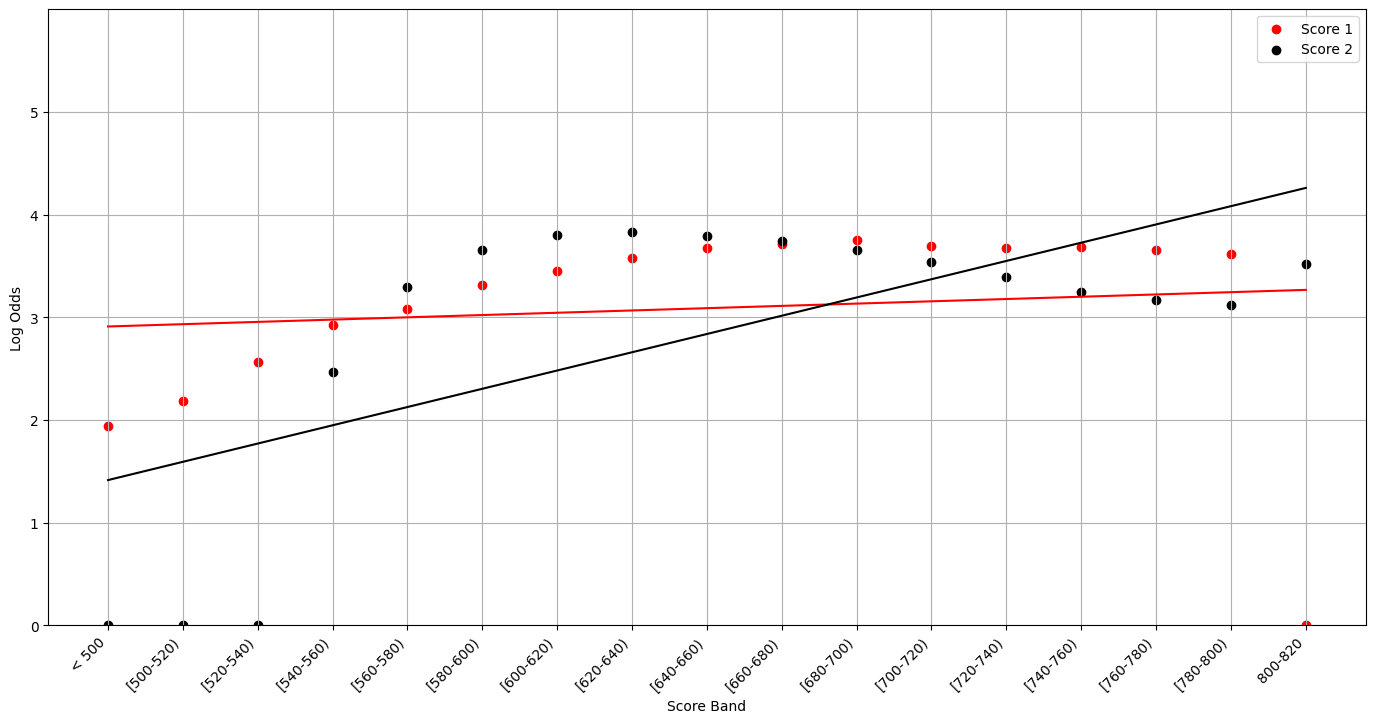

In [44]:
def plot_merged_df(color1, color2, y_ticks):
  labels = ['Score 1', 'Score 2']
  colors = [color1, color2]

  plot_scores_and_lines(x, [y1, y2], labels, colors)

  #Creating string list of the score bands along with their positions on x-axis
  string_list = [f"<{i}" if i<starting_bin else f"{i}-{i+bin_increment}" if i<ending_bin else f">{i}" for i in range(starting_bin, ending_bin, bin_increment)]
  string_list.insert(0, f"< {starting_bin}")

  #Adding [ ) to the x ticks
  for i in range(len(string_list)):
      if i != 0 and i != len(string_list) - 1:
          string_list[i] = "[" + string_list[i] + ")"

  number_list = [i for i in range(0, number_of_bins)]

  # Add a legend and labels for the axes
  plt.legend()
  plt.xlabel('Score Band')
  plt.ylabel('Log Odds')
  plt.ylim(0, y_ticks)
  plt.yticks(range(0, y_ticks))
  plt.xticks(number_list, string_list, rotation=45, ha='right')
  plt.grid(True)

  fig = plt.gcf()
  fig.set_size_inches(17, 8)

  # Show the plot
  plt.show()

# Example usage:
plot_merged_df("red", "black", 6)


In [45]:
# Getting various stats of each score
def get_stats(independent, score):
    if score == 1:
        dependent = y1
    else:
        dependent = y2
    slope, intercept, r_value, p_value, std_err = stats.linregress(independent, dependent)
    return slope, intercept, r_value**2, p_value, std_err

for i in range(1, 3):
    slope, intercept, r_squared, p_value, std_err = get_stats(x, i)
    print(f"Score {i}:")
    print("Slope:", slope)
    print("Intercept:", intercept)
    print("R-squared:", r_squared)
    print("P-value:", p_value)
    print("std err:", std_err)
    print("\n")


Score 1:
Slope: 0.022276161353129206
Intercept: 2.9097988625543363
R-squared: 0.01328695906838285
P-value: 0.6595466646762136
std err: 0.049565256834494746


Score 2:
Slope: 0.1778493155542139
Intercept: 1.4137075200698734
R-squared: 0.41475043283548674
P-value: 0.005269983705821013
std err: 0.05454861085684782




In [46]:

#create function which prints beta 0 and beta 1 for each score
def calculate_betas(x, y, score):
  X_mean = sum(x) / len(x)
  Y_mean = sum(y) / len(y)

  dev_X = [i - X_mean for i in x]
  dev_Y = [j - Y_mean for j in y]

  SS_xy = sum([dev_X[i] * dev_Y[i] for i in range(len(x))])
  SS_xx = sum([(j - X_mean)**2 for j in x])

  beta1 = SS_xy / SS_xx
  beta0 = Y_mean - beta1 * X_mean

  return beta1, beta0, score


b1_line1, b0_line1, s1 = calculate_betas(x, y1, "Score 1")
b1_line2, b0_line2, s2 = calculate_betas(x, y2, "Score 2")

In [47]:
def get_table(bottom_color=str, top_color=str, size=int, num_of_dec=int):
  #organizing data for table, calculate PDO which is the natural logarithm of base 2 / beta 1's for each score

  table_data = [['Variable', 'Score 1', 'Score 2'],
          ['Intercept β0', round(b0_line1, num_of_dec), round(b0_line2, num_of_dec)],
          ['Coefficient β1', round(b1_line1, num_of_dec), round(b1_line2, num_of_dec)],
          ['PDO', round(math.log(2)/b1_line1, num_of_dec), round(math.log(2)/b1_line2, num_of_dec)]]
  # set the colors for the table
  colors = [[top_color] * 3]  # set top row to light gray
  for i in range(1, len(table_data)):
      colors.append([bottom_color] * 3)  # set all other rows to white
  # create the table plot
  fig, ax = plt.subplots()
  ax.axis('off')  # remove axes
  # plot the table using table function
  table = ax.table(cellText=table_data, cellColours=colors, loc='center')
  # set table properties
  table.set_fontsize(size)
  table.scale(1, 2)  # set table size
  # display the plot
  plt.show()

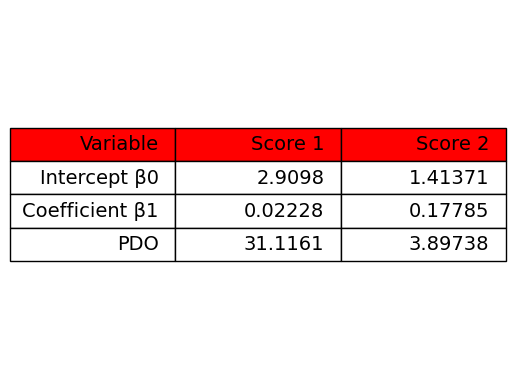

In [48]:
get_table("white", "red", 14, 5)

In [49]:
df_woe = df_concat[["Total # (S1)", "Bads # (S1)", "Total # (S2)", "Bads # (S2)"]]

def get_goods(df, number_of_scores):

  for i in range(1, number_of_scores+1):
    df[f"Goods # (S{i})"] = df[f"Total # (S{i})"] - df[f"Bads # (S{i})"]

  return df

get_goods(df_woe, 2)

<ipython-input-49-a6f8140071f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"Goods # (S{i})"] = df[f"Total # (S{i})"] - df[f"Bads # (S{i})"]


,Total # (S1),Bads # (S1),Total # (S2),Bads # (S2),Goods # (S1),Goods # (S2)
"[0.0, 500.0)",88.0,77.0,0.0,0.0,11.0,0.0
"[500.0, 520.0)",153.0,136.0,0.0,0.0,17.0,0.0
"[520.0, 540.0)",366.0,306.0,0.0,0.0,60.0,0.0
"[540.0, 560.0)",848.0,684.0,292.0,198.0,164.0,94.0
"[560.0, 580.0)",1208.0,939.0,1957.0,1240.0,269.0,717.0
"[580.0, 600.0)",2062.0,1509.0,4523.0,2698.0,553.0,1825.0
"[600.0, 620.0)",2814.0,1906.0,6321.0,3408.0,908.0,2913.0
"[620.0, 640.0)",3754.0,2232.0,6793.0,3080.0,1522.0,3713.0
"[640.0, 660.0)",4760.0,2492.0,6229.0,2382.0,2268.0,3847.0
"[660.0, 680.0)",5132.0,2278.0,5575.0,1840.0,2854.0,3735.0


In [50]:
def move_column(df, column_name, position):
    column_index = df.columns.get_loc(column_name)
    df.insert(position, column_name, df.pop(column_name))

    return df

move_column(df_woe, "Goods # (S1)", 2)

,Total # (S1),Bads # (S1),Goods # (S1),Total # (S2),Bads # (S2),Goods # (S2)
"[0.0, 500.0)",88.0,77.0,11.0,0.0,0.0,0.0
"[500.0, 520.0)",153.0,136.0,17.0,0.0,0.0,0.0
"[520.0, 540.0)",366.0,306.0,60.0,0.0,0.0,0.0
"[540.0, 560.0)",848.0,684.0,164.0,292.0,198.0,94.0
"[560.0, 580.0)",1208.0,939.0,269.0,1957.0,1240.0,717.0
"[580.0, 600.0)",2062.0,1509.0,553.0,4523.0,2698.0,1825.0
"[600.0, 620.0)",2814.0,1906.0,908.0,6321.0,3408.0,2913.0
"[620.0, 640.0)",3754.0,2232.0,1522.0,6793.0,3080.0,3713.0
"[640.0, 660.0)",4760.0,2492.0,2268.0,6229.0,2382.0,3847.0
"[660.0, 680.0)",5132.0,2278.0,2854.0,5575.0,1840.0,3735.0


In [51]:
def get_woe(df, number_of_scores):

  df = df.copy()

  for i in range(1, number_of_scores+1):
    df[f"Total Dist (S{i})"] = df[f"Total # (S{i})"]/sum(df[f"Total # (S{i})"])
    df[f"Bad Dist (S{i})"] = df[f"Bads # (S{i})"]/sum(df[f"Bads # (S{i})"])
    df[f"Goods Dist (S{i})"] = df[f"Goods # (S{i})"]/sum(df[f"Goods # (S{i})"])
    df[f'WOE (S{i})'] = np.log(df[f"Goods # (S{i})"] / df[f"Bads # (S{i})"])

  df.fillna(0, inplace=True)

  return df

df_woe = get_woe(df_woe, 2)
df_woe

,Total # (S1),Bads # (S1),Goods # (S1),Total # (S2),Bads # (S2),Goods # (S2),Total Dist (S1),Bad Dist (S1),Goods Dist (S1),WOE (S1),Total Dist (S2),Bad Dist (S2),Goods Dist (S2),WOE (S2)
"[0.0, 500.0)",88.0,77.0,11.0,0.0,0.0,0.0,0.001760,0.004038,0.000356,-1.945910,0.000000,0.000000,0.000000,0.000000
"[500.0, 520.0)",153.0,136.0,17.0,0.0,0.0,0.0,0.003060,0.007132,0.000550,-2.079442,0.000000,0.000000,0.000000,0.000000
"[520.0, 540.0)",366.0,306.0,60.0,0.0,0.0,0.0,0.007320,0.016046,0.001940,-1.629241,0.000000,0.000000,0.000000,0.000000
"[540.0, 560.0)",848.0,684.0,164.0,292.0,198.0,94.0,0.016960,0.035868,0.005302,-1.428091,0.005840,0.010383,0.003039,-0.744972
"[560.0, 580.0)",1208.0,939.0,269.0,1957.0,1240.0,717.0,0.024160,0.049240,0.008697,-1.250104,0.039141,0.065024,0.023182,-0.547791
"[580.0, 600.0)",2062.0,1509.0,553.0,4523.0,2698.0,1825.0,0.041241,0.079130,0.017880,-1.003844,0.090462,0.141479,0.059006,-0.390931
"[600.0, 620.0)",2814.0,1906.0,908.0,6321.0,3408.0,2913.0,0.056281,0.099948,0.029358,-0.741518,0.126423,0.178710,0.094183,-0.156942
"[620.0, 640.0)",3754.0,2232.0,1522.0,6793.0,3080.0,3713.0,0.075082,0.117042,0.049209,-0.382873,0.135863,0.161510,0.120049,0.186911
"[640.0, 660.0)",4760.0,2492.0,2268.0,6229.0,2382.0,3847.0,0.095202,0.130676,0.073329,-0.094187,0.124582,0.124908,0.124382,0.479353
"[660.0, 680.0)",5132.0,2278.0,2854.0,5575.0,1840.0,3735.0,0.102642,0.119455,0.092276,0.225424,0.111502,0.096487,0.120760,0.707982


In [52]:
def get_iv(df):
    iv_scores = [0] * 2

    for i in range(1, 3):
        col_goods_dist = f"Goods Dist (S{i})"
        col_bad_dist = f"Bad Dist (S{i})"
        col_woe = f"WOE (S{i})"

        iv_scores[i-1] = sum((df[col_goods_dist] - df[col_bad_dist]) * df[col_woe])

    return tuple(iv_scores)

iv_age_1, iv_age_2 = get_iv(df_woe)

print("IV age 1 score =", iv_age_1)
print("IV age 2 score =", iv_age_2)

IV age 1 score = 0.9659916116263331
IV age 2 score = 0.4139996673784305


An Information Value (IV) score comes from information theory, it measures the predictive power of independent variables which is useful in feature selection.

A score of 0.3 - 0.5 indicates a strong predictive power

A score of > 0.5 indicates suspicious pedictive power

Calculate Probability of Deafult and Exposure at Default

In [53]:
def calc_metrics(df, exposure_amount, number_of_scores):
    columns_to_display = []

    for i in range(1, number_of_scores + 1):
        col_pd = f'PD (S{i})'
        col_ead = f'EAD (S{i})'
        columns_to_display.extend([col_pd, col_ead])

        df[col_pd] = 0.0
        df[col_ead] = 0.0

    # Calculate PD, EAD, and LGD for each row
    for index, row in df.iterrows():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            pd_s1 = row['Bads # (S1)'] / row['Total # (S1)']
            pd_s2 = row['Bads # (S2)'] / row['Total # (S2)']

        ead_s1, ead_s2 = exposure_amount * pd_s1, exposure_amount * pd_s2
        lgd_s1, lgd_s2 = 0.5, 0.5

        for i in range(1, number_of_scores + 1):
            df.at[index, f'PD (S{i})'] = locals()[f'pd_s{i}']
            df.at[index, f'EAD (S{i})'] = locals()[f'ead_s{i}']

    return df[columns_to_display]

In [54]:
df = calc_metrics(df_concat, 2000, 2)
df

,PD (S1),EAD (S1),PD (S2),EAD (S2)
"[0.0, 500.0)",0.875000,1750.000000,NaN,NaN
"[500.0, 520.0)",0.888889,1777.777778,NaN,NaN
"[520.0, 540.0)",0.836066,1672.131148,NaN,NaN
"[540.0, 560.0)",0.806604,1613.207547,0.678082,1356.164384
"[560.0, 580.0)",0.777318,1554.635762,0.633623,1267.245784
"[580.0, 600.0)",0.731814,1463.627546,0.596507,1193.013487
"[600.0, 620.0)",0.677328,1354.655295,0.539155,1078.310394
"[620.0, 640.0)",0.594566,1189.131593,0.453408,906.815840
"[640.0, 660.0)",0.523529,1047.058824,0.382405,764.809761
"[660.0, 680.0)",0.443882,887.763055,0.330045,660.089686
